In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
from configparser import ConfigParser
import pathlib as pl
from itertools import combinations

import joblib as jl
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from webcolors import name_to_hex

from src.data.rasters import load_site_formated_raster
from src.root_path import config_path, root_path
from src.utils.subsets import good_sites
from src.metrics.simple_diff import ctx_effects_as_DF

from src.models.decoder import unfold_rep_ctx_prb, get_svm_accuracy
from src.data.diagonalization import diag_and_scale, load_site_dense_raster
from src.data.region_map import region_map
from src.visualization.palette import *

from src.visualization.interactive import plot_site_coverages, plot_eg_diag

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

figfolder = root_path / 'reports' / 'figures' / 'paper'
figfolder.mkdir(parents=True, exist_ok=True)

# purpose
code corresponding to figure 4 treating the diagonalization (densification) of sparse data and the associated changes
in decoding accuracy.
The code was coppied over from '230220_diagonalization_functionalized.ipynb', cleaned and extended
to generate related supplementary figures

In [130]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

# example from figure 1?
eg_cellid, eg_ctx_pair, eg_prb = 'ARM021b-36-8', [0, 1], 3  # example from figure 2, with nice PSTHs
# eg_cellid, eg_ctx_pair, eg_prb = 'ARM017a-39-2', [0,1], 3
eg_site = eg_cellid.split('-')[0]

# load cache of sigle cell rasters for this example site
if load_site_formated_raster.check_call_in_cache(eg_site, **raster_meta):
    raster, cellids = load_site_formated_raster(eg_site, **raster_meta)
    print(f'####\n'
          f'found and loaded cache for {eg_site}')
else:
    print(f"cant load load_site_formated_raster with {raster_meta}.\n this should be cached, why is it failing? ")


####
found and loaded cache for ARM021b


In [131]:
# allso loads full raster including context section to make the graphical abstract
if load_site_formated_raster.check_call_in_cache(eg_site, part='all', **raster_meta):
    fullraster, _ = load_site_formated_raster(eg_site, part='all', **raster_meta)
    print(f'####\n'
          f'found and loaded cache for {eg_site}')
else:
    print(f"cant load load_site_formated_raster with {raster_meta}.\n this should be cached, why is it failing? ")

####
found and loaded cache for ARM021b


## select an example
Simplest  2 neurons 2 probes and 3 contexts
to display in the diagonalization example. we want the instance to be as different
as possible between them and between neurons.
looking



['ARM021b-36-8' 'ARM021b-43-8' 'dense']


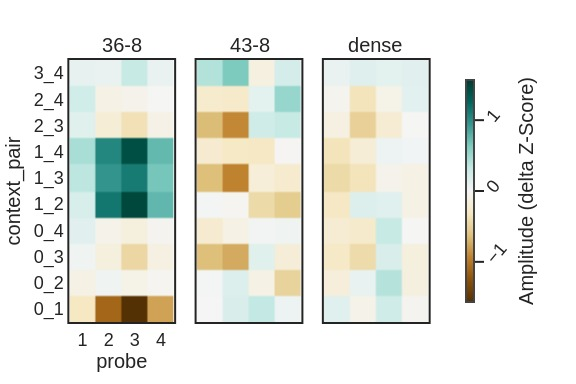

In [132]:
dense_raster, _ = load_site_dense_raster(eg_site, **raster_meta)

# good looking examples... i hope.
# eg_neurons = ["ARM021b-" + ci for ci in ['36-8', '43-8']] # original order
eg_neurons = ["ARM021b-" + ci for ci in
              ['43-8', '36-8']]  # inverted order for vertical layout, this order influence xy axis in ellipse plot
eg_probes = [3, 4]
# eg_ctxs = [0,1,2,3,4]
eg_ctxs = [1, 2, 3]
eg_ctx_pairs = list(combinations(eg_ctxs, 2))

eg_times = [5]  # empirically determined later on

sparse_df = ctx_effects_as_DF(raster, cellids, raster_meta['raster_fs'], abs=False
                              ).query(f"chunk == 'Full' and id in {eg_neurons}")  # simple diff
# hack appende dense converage

dense_df = ctx_effects_as_DF(dense_raster, cellids, raster_meta['raster_fs'], abs=False
                             ).query(f"chunk == 'Full' and id == '{eg_neurons[0]}'")
dense_df['id'] = 'dense'

toplot_df = pd.concat((sparse_df, dense_df))

fig = plot_site_coverages(toplot_df, has_neg=True)
fig.update_layout(height=96 * 2, width=96 * 3)

filename = figfolder / 'fig4_dense_coverages'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

## simple PSTHs
to compress the information of the pairwise comparisons for two neurons and with sparse and dense, we can just consider
the PSHT of all compared instances together. Furthermore, we can also plot the probe PHSTs , i.e., the context average.
This is useful insofar as it shows that the overal probe PSTH does not change during densification, only the individual
instances

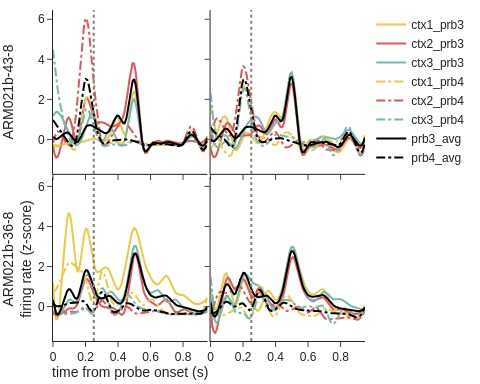

In [133]:
# try to compress all inte information about a single neuron in a single pannel
from scipy.interpolate import make_interp_spline


def simple_psths(fnArrs: list[np.array],
                 cellids: list[str],
                 cells: list[str],
                 contexts: list[int],
                 probes: list[int],
                 part: str = 'probe',
                 avg: str ='all',
                 color_palette: list[str] = FOURCOLOR) -> go.Figure:
    cidxs = [cellids.index(c) for c in cells]
    prbidxs = [p - 1 for p in probes]

    PSTHs = [a.mean(axis=0) for a in fnArrs]
    chn, ctx, prb, tme = PSTHs[0].shape

    if part == 'probe':
        t = np.linspace(0, 1, tme, endpoint=False)
    elif part == 'all':
        t = np.linspace(-1, 1, tme, endpoint=False)
    else:
        raise ValueError("parameter part must be 'all' or 'probe'")

    dashings = ['dot', 'dash', 'solid', 'dashdot']

    # rows, cols = square_rows_cols(len(cellid))
    fig = make_subplots(len(cells), len(fnArrs), shared_xaxes='all', shared_yaxes='all',
                        vertical_spacing=0.01, horizontal_spacing=0.01)

    pan = 0
    for col, psth in enumerate(PSTHs):
        for row, cidx in enumerate(cidxs):
            # row, col = int(np.floor(cc / cols)) + 1, (cc % cols) + 1
            showlegend = True if pan == 0 else False
            pan = + 1

            # individual context probe lines
            for prbidx in prbidxs:
                dash = dashings[prbidx]

                for ctxidx in contexts:
                    color = color_palette[ctxidx]
                    y = psth[cidx, ctxidx, prbidx, :]
                    # tt, yy = squarefy(t, y)
                    # tt, yy = t, y
                    tt = np.linspace(t.min(), t.max(), 100)
                    yy = make_interp_spline(t, y, k=3)(tt)

                    fig.add_trace(go.Scatter(x=tt, y=yy, mode='lines', line=dict(color=color, dash=dash, width=2),
                                             name=f"ctx{ctxidx}_prb{prbidx + 1}", showlegend=showlegend),
                                  row=row + 1, col=col + 1)

            # probe PSTH, all contexts averaged
            # in new for loop to ensure averages are on top of instace lines
            for prbidx in prbidxs:
                dash = dashings[prbidx]

                if avg == 'all':
                    y = psth[cidx, :, prbidx, :].mean(axis=0)
                elif avg == 'visible':
                    y = psth[cidx, contexts, prbidx, :].mean(axis=0)
                else:
                     raise ValueError("parameter avg must be 'all' or 'visible'")
                # tt, yy = squarefy(t, y)
                # tt, yy = t, y
                tt = np.linspace(t.min(), t.max(), 100)
                yy = make_interp_spline(t, y, k=3)(tt)
                fig.add_trace(go.Scatter(x=tt, y=yy, mode='lines', line=dict(color='black', dash=dash, width=2),
                                         name=f"prb{prbidx + 1}_avg", showlegend=showlegend),
                              row=row + 1, col=col + 1)

            # add neuron name on left column
            if col == 0:
                # skips last row since its treated differently
                if row < len(cells) - 1:
                    _ = fig.update_yaxes(title_text=f'{cells[row]}<br> ', title_standoff=0,
                                         row=row + 1, col=1)

    _ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0,
                         row=len(cells), col=1)
    _ = fig.update_yaxes(title_text=f'{cells[-1]}<br>firing rate (z-score)', title_standoff=0,
                         row=len(fnArrs), col=1)

    fig.update_layout(template='simple_white',
                      margin=dict(b=10, l=10, r=10, t=10))

    return fig


fig = simple_psths([raster, dense_raster], cellids, eg_neurons, eg_ctxs, eg_probes)

fig.add_vline(eg_times[0] * 1 / 20, line_color='gray', line_dash='dot', line_width=2, opacity=1)
fig.update_layout(height=96 * 4, width=96 * 5)

filename = figfolder / 'fig4_dense_psths'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

### Graphical abstract
simpler PSTH including context. Probably colors will be changed in inkscape

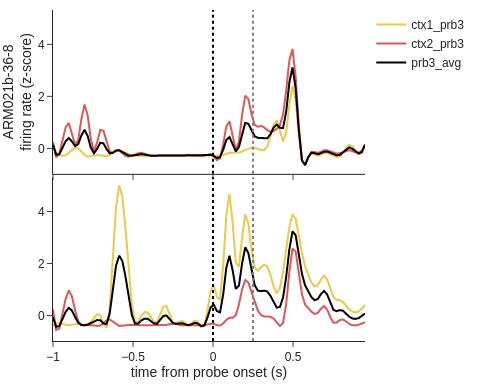

In [134]:

# fig = simple_psths([fullraster], cellids, eg_neurons, eg_ctxs, eg_probes, part='all')
fig = simple_psths([fullraster], cellids, eg_neurons, [1,2], [3], part='all', avg='visible')
fig.add_vline(eg_times[0] * 1 / 20, line_color='gray', line_dash='dot', line_width=2, opacity=1)
fig.add_vline(0, line_color='black', line_dash='dot', line_width=2, opacity=1)
fig.update_layout(height=96 * 4, width=96 * 5)

filename = figfolder / 'fig0_sparse_psth'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

## example time point
Lets plot the 2 neuron state space for those 2 probes, 3 context and one time point

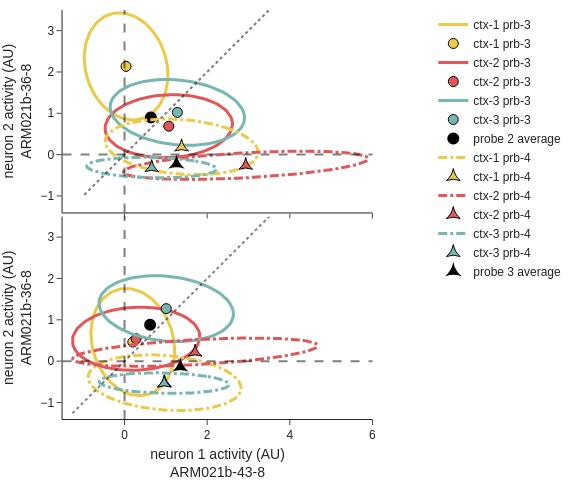

In [135]:
rep, chn, ctx, prb, tme = raster.shape
# smart index to select all reps for 2 neurons, all contexts, two probes and one time point
idxr = np.ix_(np.arange(rep),
              [cellids.index(cid) for cid in eg_neurons],
              eg_ctxs,
              np.asarray(eg_probes) - 1,
              eg_times)

fig = plot_eg_diag([raster, dense_raster],
                   idxr, trial_mode='ellipse', n_std=1, jitter=0.3,
                   orientation='v')

fig.update_layout(height=96 * 5, width=96 * 6,
                  margin=dict(l=10, r=10, t=10, b=10),
                  showlegend=True)

# axis labels
_ = fig.update_xaxes(title=dict(text=f'neuron 1 activity (AU)<br>{eg_neurons[0]}', standoff=0),
                     row=2, col=1)
_ = fig.update_yaxes(title=dict(text=f'neuron 2 activity (AU)<br>{eg_neurons[1]}', standoff=0))
fig.update_xaxes(constrain='domain', range=[-1.5, 6])
fig.update_yaxes(constrain='domain', range=[-1.4, 3.5])

filename = figfolder / 'fig4_dense_scatter'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

### graphical abstract
same as above but only presserving one probe and two contexts, also diagonalization is done on the data subset

In [144]:
rep, chn, ctx, prb, tme = raster.shape
# smart index to select all reps for 2 neurons, all contexts, two probes and one time point
idxr = np.ix_(np.arange(rep),
              [cellids.index(cid) for cid in eg_neurons],
              [1,2],
              np.asarray([3]) - 1,
              eg_times)

subraster = raster[idxr].copy()
dense_subraster = diag_and_scale(subraster.copy(), mode='mean_var')

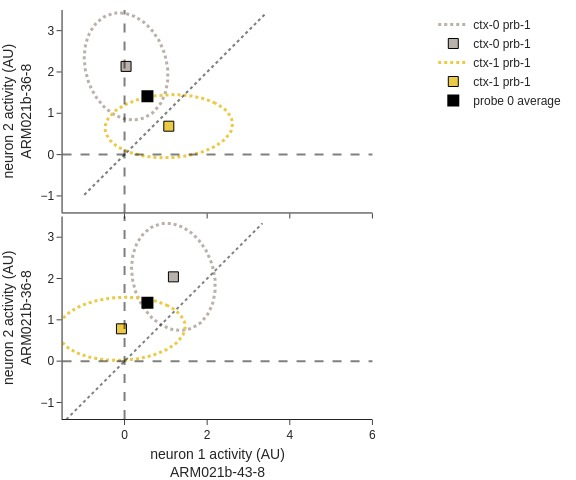

In [145]:
# cludge to use the same function, passing sliced array indtead of the full one
subidxr = np.ix_(np.arange(rep),
              [0,1],
              [0,1],
              [0],
              [0])


fig = plot_eg_diag([subraster, dense_subraster],
                   subidxr, trial_mode='ellipse', n_std=1, jitter=0.3,
                   orientation='v')

fig.update_layout(height=96 * 5, width=96 * 6,
                  margin=dict(l=10, r=10, t=10, b=10),
                  showlegend=True)

# axis labels
_ = fig.update_xaxes(title=dict(text=f'neuron 1 activity (AU)<br>{eg_neurons[0]}', standoff=0),
                     row=2, col=1)
_ = fig.update_yaxes(title=dict(text=f'neuron 2 activity (AU)<br>{eg_neurons[1]}', standoff=0))
fig.update_xaxes(constrain='domain', range=[-1.5, 6])
fig.update_yaxes(constrain='domain', range=[-1.4, 3.5])

filename = figfolder / 'fig0_state_spaces'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

# Decoder analysis for all sites

In [138]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'230220_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists() and not recache_acc:
    print('DF cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    print('creating DF of site decoder accuracies ...')
    accuracy_df = list()
    for site in good_sites:
        # for site in [eg_site]:
        fn = load_site_formated_raster
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")

        nsounds = raster.shape[3]
        codes = dict(sparse=raster,
                     dense=diag_and_scale(raster, mode='mean_var'))

        for code, rast in codes.items():
            unfolded, labels = unfold_rep_ctx_prb(rast)
            for part in ['context', 'probe']:
                accuracy, chance = get_svm_accuracy(unfolded, labels[part])

                d = {'site': site,
                     'code': code,
                     'part': part,
                     'accuracy': accuracy,
                     'chance': chance,
                     'nsounds': nsounds}

                accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)
    print('... done creating DF')

    jl.dump(accuracy_df, acc_df_file)

accuracy_df['region'] = accuracy_df['site']
accuracy_df.replace({'region':region_map}, inplace=True)

for col in ['site', 'code', 'part', 'chance', 'nsounds', 'region']:
    accuracy_df[col] = accuracy_df[col].astype('category')


DF cache found, reloading


### plots the cumulative data
lets see how the decoder analysis performs for all sites in their starting sparse encoding, and then once transformed
to the different dense codes

In [139]:
def plot_acc_from_df(fnDF, part, code, nsounds, color='black', showlegend=False):
    # transfroms color into hex if necesary
    if color[0] != '#':
        color = name_to_hex(color)

    fig = go.Figure()
    indf = fnDF.query(f"part=='{part}' and code=='{code}' and nsounds=={nsounds}")
    chance = indf.chance.unique()[0]
    arr = np.stack(indf.loc[:, 'accuracy'].values)

    t = np.linspace(0, 1, arr.shape[1], endpoint=True)  # hardcoded 0 to 1 timeframe, fine for now
    # individual lines, damn you plotly for this verbose monster
    for l in arr:
        fig.add_trace(
            go.Scatter(x=t, y=l, mode='lines', opacity=0.3, showlegend=False,
                       line=dict(color=add_opacity(color, 0.3)),
                       )
        )

    # mean of all lines
    fig.add_trace(
        go.Scatter(x=t, y=arr.mean(axis=0), mode='lines', showlegend=showlegend,
                   line=dict(color=color), name=f'{part}_{code}'
                   )
    )

    # chance line
    fig.add_trace(
        go.Scatter(x=[t[0], t[-1]], y=[chance] * 2, mode='lines', showlegend=showlegend,
                   line=dict(color=color, dash='dot'), name=f'chance={chance:.2f}'
                   )
    )

    return fig

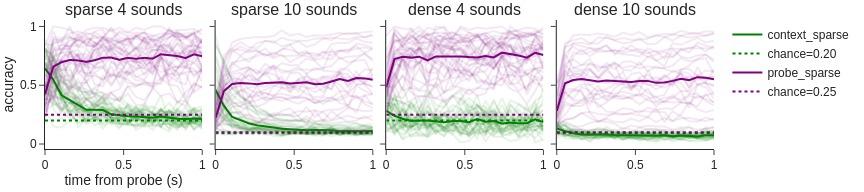

In [140]:
from itertools import product

encodings = ['sparse', 'dense']
parts = ['context', 'probe']
nsounds = [4, 10]
colors = ['green', 'purple']

fig = make_subplots(rows=1, cols=4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{e} {n} sounds" for e, n in product(encodings, nsounds)],
                    vertical_spacing=0.02, horizontal_spacing=0.02)

ii = 0
for cc, code in enumerate(encodings):
    for rr, ns in enumerate(nsounds):
        col = rr + 1 + (cc) * 2
        showlegend = True if ii == 0 else False
        ii += 1
        for part, color in zip(parts, colors):
            f = plot_acc_from_df(accuracy_df, part, code, nsounds=ns, color=color, showlegend=showlegend)['data']
            fig.add_traces(f, rows=[1] * len(f), cols=[col] * len(f))

fig.update_yaxes(title=dict(text=f'accuracy', standoff=0), row=1, col=1)
fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0), row=1, col=1)

fig.update_layout(height=96 * 2, width=96 * 9,
                  template='simple_white',
                  margin={'t': 20, 'l': 10, 'b': 10, 'r': 10})

filename = figfolder / 'fig4_decoder_accuracies'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

### Simplified
here I just keep the 10 sound examples and organize the vertically

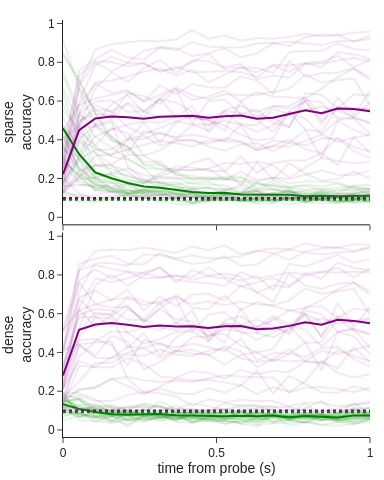

In [141]:
encodings = ['sparse', 'dense']
parts = ['context', 'probe']
colors = ['green', 'purple']

fig = make_subplots(rows=2, cols=1, shared_xaxes='all', shared_yaxes='all',
                    vertical_spacing=0.02, horizontal_spacing=0.02)

for cc, code in enumerate(encodings):
    showlegend = True if cc == 0 else False
    for part, color in zip(parts, colors):
        f = plot_acc_from_df(accuracy_df, part, code, nsounds=10, color=color, showlegend=showlegend)['data']
        fig.add_traces(f, rows=[cc + 1] * len(f), cols=[1] * len(f))

fig.update_yaxes(title=dict(text=f'sparse<br>accuracy', standoff=0), row=1, col=1)
fig.update_yaxes(title=dict(text=f'dense<br>accuracy', standoff=0), row=2, col=1)
fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0),
                 row=2, col=1)

fig.update_layout(height=96 * 5, width=96 * 4,
                  template='simple_white',
                  margin={'t': 20, 'l': 10, 'b': 10, 'r': 10},
                  showlegend=False)

filename = figfolder / 'fig4_decoder_accuracies_simple'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

# supplementary figures
split decoder accuarcy by brain region, also include the 4 sound data

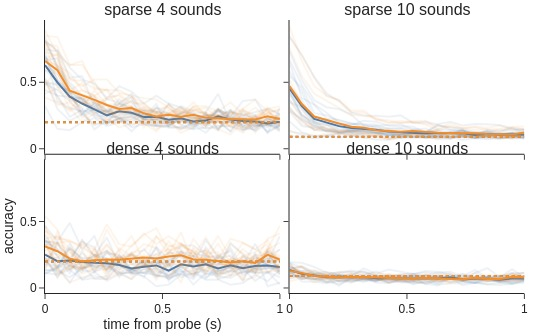

In [142]:
from src.visualization.palette import A1_COLOR, PEG_COLOR
from itertools import product

encodings = ['sparse', 'dense']
regions = ['A1', 'PEG']
colors = [A1_COLOR, PEG_COLOR]
nsounds = [4, 10]

fig = make_subplots(rows=2, cols=2, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{e} {n} sounds" for e, n in product(encodings, nsounds)],
                    vertical_spacing=0.02, horizontal_spacing=0.02)

ii = 0
for rr, code in enumerate(encodings):
    for cc, ns in enumerate(nsounds):
        # col = rr + 1 + (cc) * 2
        row = rr + 1
        col = (cc%2) +1
        # showlegend = True if ii == 0 else False
        ii += 1
        for region, color in zip(regions, colors):
            f = plot_acc_from_df(accuracy_df.query(f"region == '{region}'"),
                                 'context', code, nsounds=ns, color=color, showlegend=showlegend)['data']
            fig.add_traces(f, rows=[row] * len(f), cols=[col] * len(f))

fig.update_yaxes(title=dict(text=f'accuracy', standoff=0), row=2, col=1)
fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0), row=2, col=1)

fig.update_layout(height=96 * 5 * 0.7, width=96 * 8 * 0.7,
                  template='simple_white',
                  margin={'t': 20, 'l': 10, 'b': 10, 'r': 10})

filename = figfolder / 'sup_fig2_decoder_accuracies'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

In [143]:
accuracy_df.loc[:, ['part', 'chance', 'nsounds']].drop_duplicates()

,part,chance,nsounds
0,context,0.200000,4
1,probe,0.250000,4
4,context,0.090909,10
5,probe,0.100000,10
128,context,0.100000,9
129,probe,0.111111,9
